# Breast Cancer 


breast_benign     Benign 

breast_malignant  Malignant


Main Classes   -   1

Sub Classes   -   2

Each Sub-Class contains 5000 Images

Format   -   JPEG

Dimensions   -   512px X 512px

In [1]:
 ! pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [150]:
!kaggle datasets download -d obulisainaren/multi-cancer

100% 8.61G/8.62G [04:48<00:00, 35.9MB/s]
100% 8.62G/8.62G [04:49<00:00, 32.0MB/s]


In [ ]:
!unzip multi-cancer.zip


In [152]:
base_path='/content/Multi Cancer/Breast Cancer'

# import needed libraries 

In [153]:
from keras.layers import Input, Lambda, Dense, Flatten
from skimage.io import imshow,imread
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation,Conv2D, MaxPool2D ,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import seaborn as sns
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
import pandas as pd

In [154]:
batch_size = 32
img_height = 224
img_width = 224
target_size=(224, 224)
IMG_SIZE=224
class_mode='categorical'

# image data generator 

In [155]:
def generate_dataset(path):
  print("\nTotal for trainning and validation : ", end=" ")
  train_ds = image_dataset_from_directory(path,
                                          image_size=(img_height, img_width),
                                          batch_size=batch_size)
 
  class_names = train_ds.class_names
  print(class_names)
  num_classes=len(train_ds.class_names)


  train_datagen = ImageDataGenerator(rescale = 1./255,
                                      fill_mode = 'nearest',
                                      samplewise_std_normalization=True,
                                      samplewise_center=True,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     validation_split=0.3

                                      )

  print("\nFor Training : ", end=" ")
  train_generator = train_datagen.flow_from_directory(path,
                                                      target_size=target_size,
                                                      batch_size=batch_size,
                                                      class_mode='categorical',
                                                      subset='training',
                                                      interpolation="nearest",
                                                      color_mode='rgb')
    
 
  print("\nFor Val : ", end=" ")
  validation_generator = train_datagen.flow_from_directory(path,
                                                           target_size=target_size,
                                                           batch_size=batch_size,
                                                           class_mode='categorical',
                                                           subset='validation',
                                                           shuffle=False,
                                                           interpolation="nearest",
                                                           color_mode='rgb')
  plt.figure(figsize=(30, 30))
  for images, labels in train_ds.take(1):
    for i in range(num_classes):
      ax = plt.subplot(9, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[labels[i]]) 
      plt.axis("off")
 
   

  
  print(train_generator.batch_size)
  print(train_generator.image_shape)
  print(validation_generator.image_shape)
  
  return train_generator,validation_generator,train_generator.image_shape,class_names,num_classes

#VGG16 Model

In [156]:
def initiate_model_VGG16(no_of_classes, image_size,fine_tune=0):
  vgg=VGG16(include_top=False,
            weights='imagenet',
            input_tensor=None,
            input_shape=image_size,
            pooling=None,
            classes=no_of_classes
  )
  if fine_tune > 0:
        for layer in vgg.layers[:-fine_tune]:
            layer.trainable = False
  else:
        for layer in vgg.layers:
            layer.trainable = False  
       
  top_model = Flatten(name="flatten")(vgg.output)
  top_model = Dense(4096, activation='relu')(top_model)
  top_model = Dense(1072, activation='relu')(top_model)
  top_model = Dropout(0.2)(top_model)
  output_layer  = Dense(no_of_classes, activation='softmax')(top_model)

  model = Model(inputs=vgg.input, outputs= output_layer,name="VGG16")
  return model

##Model Summary

In [157]:
def modelSummary(model):
    model.summary()

#Model compile and set check point and callbacks

In [158]:
def initiateParams_modelComplie(model, learning_rate):
  optimizer=Adam(learning_rate=learning_rate)

  model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics = [tf.keras.metrics.Recall()]
                )
  rlr = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.5,
                               patience=4,
                               verbose=1,
                               mode='auto',
                               min_lr=1e-5,
                               min_delta=0.001)
  
  checkpoint = ModelCheckpoint('VGG16.h5',
                               verbose=1,
                               save_best_only=True)
    
  return model,rlr, checkpoint

## model fit

In [159]:
def modelFit(model, rlr, checkpoint, epochs=20, batchSize = 32):

    model_fit = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs,
      batch_size=batchSize,
      callbacks=[rlr, checkpoint],
      steps_per_epoch=len(train_ds),
      validation_steps=len(val_ds)
    )

    return model_fit

##Model Evaluation

In [160]:
def evalModel(model):
    evl = model.evaluate(val_ds)
    acc = evl[1]*100
    msg=f'Precision on the Test Set = {acc:5.2f} %'
    print(msg)
    return acc


## function that save model

In [161]:
def saveModel(model):
    model.save("VGG16.h5")
    print("Model Saved!")

##visualize model preformance

In [172]:
def plotOutput(hist_vgg):
    acc_vgg = hist_vgg.history['recall_16']
    val_acc_vgg = hist_vgg.history['val_recall_16']

    loss_vgg = hist_vgg.history['loss']
    val_loss_vgg =hist_vgg.history['val_loss']

    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(acc_vgg, label='Training recall')
    plt.plot(val_acc_vgg, label='Validation recall')
    plt.legend(loc='lower right')
    plt.xlabel('Epochs')
    plt.ylabel('recall')
    
    
    
    
    plt.title('Training and Validation recall ')
    
    plt.subplot(3, 2, 2)
    plt.plot( loss_vgg, label='Training Loss')
    plt.plot( val_loss_vgg, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.xlabel('Epochs')
    plt.ylabel('loss')
    plt.title('Training and Validation Loss')
    
    plt.show()
    plt.savefig('_graph.png')

##confusion matrix

In [177]:
def plot_confusion_matrix(model,classes, normalize=True):

    title='Confusion matrix'
    y_true = val_ds.classes
    y_pred = model.predict(val_ds)
    y_pred = np.argmax(y_pred, axis=1)
    conf_mat = confusion_matrix(y_true, y_pred)

    accuracy = np.trace(conf_mat) / float(np.sum(conf_mat))
    misclass = 1 - accuracy

    cmap = plt.get_cmap('Greens')

    plt.figure(figsize=(12, 12))
    plt.imshow(conf_mat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]


    thresh = conf_mat.max() / 1.5 if normalize else conf_mat.max() / 2
    for i, j in itertools.product(range(conf_mat.shape[0]), range(conf_mat.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(conf_mat[i, j]),
                     horizontalalignment="center",
                     color="white" if conf_mat[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(conf_mat[i, j]),
                     horizontalalignment="center",
                     color="white" if conf_mat[i, j] > thresh else "black")


    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    plt.savefig(title + '.png')

Breast Cancer


Total for trainning and validation :  Found 10000 files belonging to 2 classes.
['breast_benign', 'breast_malignant']

For Training :  Found 7000 images belonging to 2 classes.

For Val :  Found 3000 images belonging to 2 classes.
32
(224, 224, 3)
(224, 224, 3)


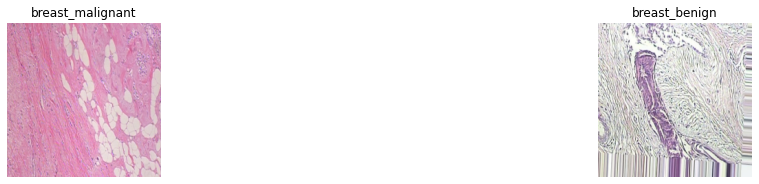

In [164]:
train_ds,val_ds,image_batch,class_names,num_classes=generate_dataset(base_path)


## VGG16 model

In [165]:
model=initiate_model_VGG16(num_classes,
                                 image_batch,fine_tune=2)


Model summary

In [166]:
modelSummary(model)

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

initiate parameters

In [167]:
model_vgg, rlr, checkpoint=initiateParams_modelComplie(model=model,
                                                       learning_rate=0.001)

Fit the Model

In [168]:
model_fit = modelFit(model_vgg,
                    rlr,
                  checkpoint,
                   epochs=20,
                   batchSize = 32)

Epoch 1/20
219/219 [==============================] - ETA: 0s - loss: 0.5160 - recall_16: 0.9666
Epoch 1: val_loss improved from inf to 0.03540, saving model to VGG16.h5
219/219 [==============================] - 134s 603ms/step - loss: 0.5160 - recall_16: 0.9666 - val_loss: 0.0354 - val_recall_16: 0.9903 - lr: 0.0010
Epoch 2/20
219/219 [==============================] - ETA: 0s - loss: 0.0364 - recall_16: 0.9901
Epoch 2: val_loss did not improve from 0.03540
219/219 [==============================] - 113s 518ms/step - loss: 0.0364 - recall_16: 0.9901 - val_loss: 0.0487 - val_recall_16: 0.9893 - lr: 0.0010
Epoch 3/20
219/219 [==============================] - ETA: 0s - loss: 0.0419 - recall_16: 0.9880
Epoch 3: val_loss improved from 0.03540 to 0.03106, saving model to VGG16.h5
219/219 [==============================] - 117s 536ms/step - loss: 0.0419 - recall_16: 0.9880 - val_loss: 0.0311 - val_recall_16: 0.9900 - lr: 0.0010
Epoch 4/20
219/219 [==============================] - ETA: 0s 

Save Model

In [169]:
saveModel(model_vgg)

Model Saved!


Model evaluation

In [170]:
accuracy=evalModel(model_vgg)

94/94 [==============================] - 29s 309ms/step - loss: 0.0483 - recall_16: 0.9933
Precision on the Test Set = 99.33 %


Model preformance

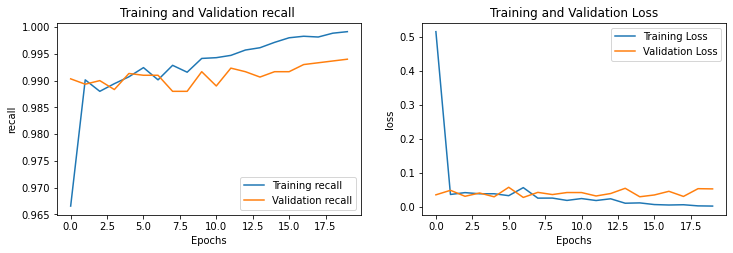

<Figure size 432x288 with 0 Axes>

In [173]:
plotOutput(hist_vgg=model_fit)

Confusion Matrix

94/94 [==============================] - 29s 313ms/step


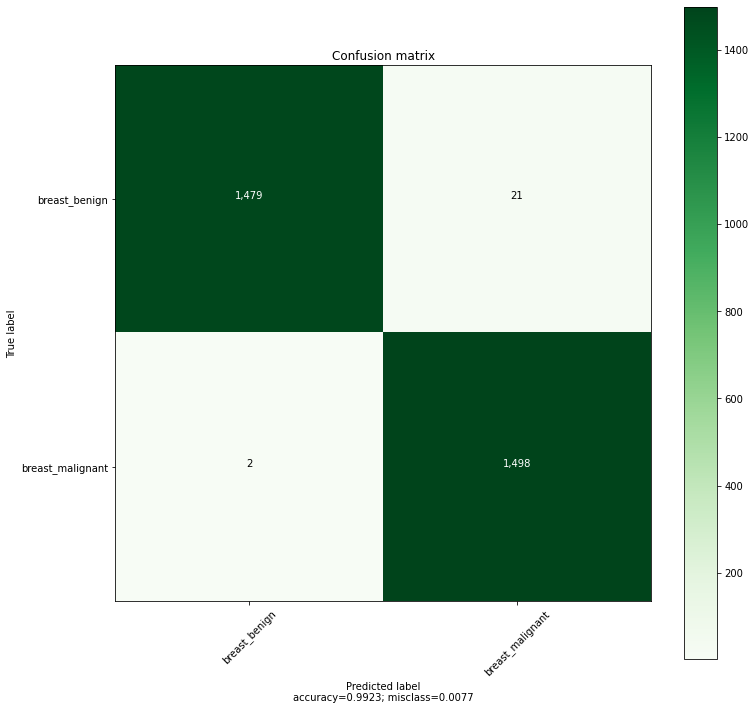

<Figure size 432x288 with 0 Axes>

In [178]:
plot_confusion_matrix(model_vgg,
                      classes=class_names,
                      normalize=False)